### Data Loaders

In [2]:
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import numpy as np
import copy

np.random.seed(42)
# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create lists to store indices for each class
indices_per_class_train = [[] for _ in range(10)]
indices_per_class_test = [[] for _ in range(10)]

# Group indices by class label
for idx, (_, label) in enumerate(train_data):
    indices_per_class_train[label].append(idx)

for idx, (_, label) in enumerate(test_data):
    indices_per_class_test[label].append(idx)

# Sample 10% of indices from each class
subset_indices_train = []
subset_indices_test = []
for class_indices_train, class_indices_test in zip(indices_per_class_train, indices_per_class_test):
    subset_indices_train.extend(np.random.choice(class_indices_train, int(0.1 * len(class_indices_train)), replace=False))
    subset_indices_test.extend(np.random.choice(class_indices_test, int(0.1 * len(class_indices_test)), replace=False))

# Create subsets using Subset class from torch.utils.data
small_train_data = Subset(train_data, subset_indices_train)
small_test_data = Subset(test_data, subset_indices_test)

# Create DataLoader for small datasets
batch_size = 64  # Adjust batch size as needed
small_train_loader = DataLoader(small_train_data, batch_size=batch_size, shuffle=True)
small_test_loader = DataLoader(small_test_data, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 103174785.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

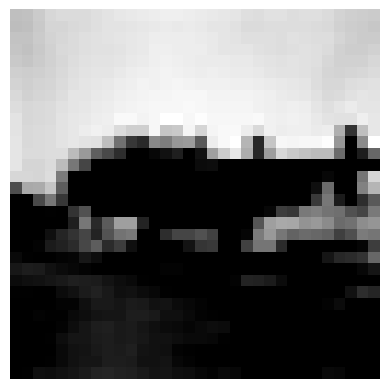

In [4]:
import torch
import matplotlib.pyplot as plt

image=small_train_data[0][0]
# Convert the tensor to a NumPy array
np_image = image.numpy()

# Reshape the NumPy array for display
reshaped_image = np.transpose(np_image, (1, 2, 0))  # Transpose dimensions to match HxWxC

# Display the image using matplotlib
plt.imshow(reshaped_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

In [5]:
import pickle
with open('small_cifar_train.pkl', 'wb') as f_train:
    pickle.dump(small_train_data, f_train)

with open('small_cifar_test.pkl', 'wb') as f_test:
    pickle.dump(small_test_data, f_test)

In [6]:
total_samples = len(small_train_data)
forget_samples = int(0.05 * total_samples)

# Generate random indices for the forget set
forget_indices = np.random.choice(total_samples, forget_samples, replace=False)
retain_indices = [idx for idx in range(total_samples) if idx not in forget_indices]

# Create forget and retain sets
forget_set = torch.utils.data.Subset(small_train_data, forget_indices)
retain_set = torch.utils.data.Subset(small_train_data, retain_indices)

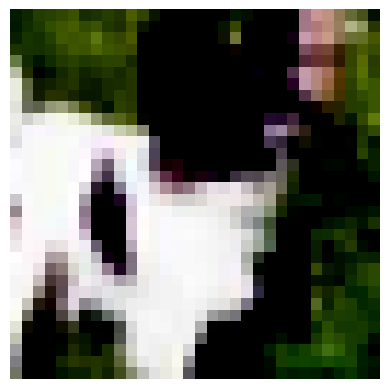

In [7]:
import torch
import matplotlib.pyplot as plt

image=forget_set[0][0]
# Convert the tensor to a NumPy array
np_image = image.numpy()

# Reshape the NumPy array for display
reshaped_image = np.transpose(np_image, (1, 2, 0))  # Transpose dimensions to match HxWxC

# Display the image using matplotlib
plt.imshow(reshaped_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

Pickle to data loader

In [8]:
with open('forget_set.pkl', 'wb') as f_train:
    pickle.dump(forget_set, f_train)

with open('retain_set.pkl', 'wb') as f_test:
    pickle.dump(retain_set, f_test)

In [9]:
from torch.utils.data import Dataset
# Define your custom dataset class inheriting from torch.utils.data.Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        return sample, label

# Load the dataset from the pickle file
with open('forget_set.pkl', 'rb') as f:
    data_list = pickle.load(f)
forget_set1 = CustomDataset(data_list)


with open('retain_set.pkl', 'rb') as f:
    data_list = pickle.load(f)
retain_set1 = CustomDataset(data_list)

retain_loader=DataLoader(retain_set1, batch_size=64, shuffle=True)
forget_loader=DataLoader(forget_set1, batch_size=64, shuffle=True)

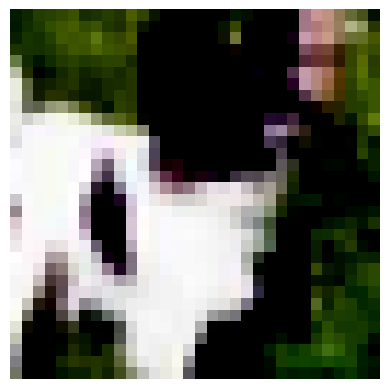

In [10]:
import torch
import matplotlib.pyplot as plt


image=forget_set1[0][0]
# Convert the tensor to a NumPy array
np_image = image.numpy()

# Reshape the NumPy array for display
reshaped_image = np.transpose(np_image, (1, 2, 0))  # Transpose dimensions to match HxWxC

# Display the image using matplotlib
plt.imshow(reshaped_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

Train original

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # L2 regularization
            l2_reg = None
            for param in model.parameters():
                if l2_reg is None:
                    l2_reg = param.norm(2)
                else:
                    l2_reg = l2_reg + param.norm(2)

            loss = loss + weight_decay * l2_reg  # Add L2 regularization to the loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        print(f"Epoch [{epoch + 1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

In [12]:
train_loader = DataLoader(small_train_data, batch_size=64, shuffle=True)
test_loader= DataLoader(small_test_data, batch_size=64, shuffle=True)

# Define the model architecture for 10 classes
model_train = models.resnet18(pretrained=True)
num_ftrs = model_train.fc.in_features
model_train.fc = nn.Linear(num_ftrs, 10)  # Output layer for 10 classes
model_train=model_train.to(device)
# L2 regularization
weight_decay = 0  # Adjust this value if needed

# Define optimizer (Adam is commonly used)
optimizer = optim.Adam(model_train.parameters(), lr=0.001, weight_decay=0.0001)  # Adjust lr if needed

# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Train the model on the entire retain set
train_model(model_train, criterion, optimizer, train_loader, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Epoch [1/10] | Loss: 1.4948
Epoch [2/10] | Loss: 1.0835
Epoch [3/10] | Loss: 0.9053
Epoch [4/10] | Loss: 0.6402
Epoch [5/10] | Loss: 0.5408
Epoch [6/10] | Loss: 0.4685
Epoch [7/10] | Loss: 0.4234
Epoch [8/10] | Loss: 0.3881
Epoch [9/10] | Loss: 0.2710
Epoch [10/10] | Loss: 0.2446


In [13]:
# Calculate accuracy on the test dataset
test_accuracy = evaluate_model(model_train, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 70.70%


### Retrain Forgetting(resnet18)

In [14]:
retain_loader = DataLoader(retain_set, batch_size=64, shuffle=True)

# Define the model architecture for 10 classes
model_retrain = models.resnet18(pretrained=True)
model_retrain.to(device)  # Move model to GPU if available
num_ftrs = model_retrain.fc.in_features
model_retrain.fc = nn.Linear(num_ftrs, 10)  # Output layer for 10 classes

# L2 regularization
weight_decay = 0  # Adjust this value if needed

# Define optimizer (Adam is commonly used)
optimizer = optim.Adam(model_retrain.parameters(), lr=0.001, weight_decay=0.0001)  # Adjust lr if needed

# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Train the model on the entire retain set
train_model(model_retrain, criterion, optimizer, retain_loader, num_epochs=10)

Epoch [1/10] | Loss: 1.5449
Epoch [2/10] | Loss: 1.0286
Epoch [3/10] | Loss: 0.7492
Epoch [4/10] | Loss: 0.5754
Epoch [5/10] | Loss: 0.4863
Epoch [6/10] | Loss: 0.4091
Epoch [7/10] | Loss: 0.3249
Epoch [8/10] | Loss: 0.3375
Epoch [9/10] | Loss: 0.2224
Epoch [10/10] | Loss: 0.1593


In [15]:
# Calculate accuracy on the test dataset
test_accuracy = evaluate_model(model_retrain, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 64.90%


In [16]:
# Calculate accuracy on the test dataset
test_accuracy = evaluate_model(model_retrain, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 94.57%


In [17]:
# Calculate accuracy on the test dataset
test_accuracy = evaluate_model(model_retrain, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 67.20%


### Scrub Unlearning

##### Helper Functions


In [18]:
def param_dist(model, swa_model, p):
    #This is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
    dist = 0.
    for p1, p2 in zip(model.parameters(), swa_model.parameters()):
        dist += torch.norm(p1 - p2, p='fro')
    return p * dist

class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate, optimizer):
    """Sets the learning rate to the initial LR decayed by decay rate every steep step"""
    steps = np.sum(epoch > np.asarray(lr_decay_epochs))
    new_lr = sgda_learning_rate
    if steps > 0:
        new_lr = sgda_learning_rate * (lr_decay_rate ** steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    return new_lr

def validate(val_loader, model, criterion, opt, quiet=False):
    """validation"""
#     batch_time = AverageMeter()
    losses = AverageMeter()
#     top1 = AverageMeter()
#     top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
#         end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
#             acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
#             top1.update(acc1[0], input.size(0))
#             top5.update(acc5[0], input.size(0))

            # measure elapsed time
#             batch_time.update(time.time() - end)
#             end = time.time()

#             if not quiet:
#                 if idx % opt.print_freq == 0:
#                     print('Test: [{0}/{1}]\t'
#                           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
#                           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
#                            idx, len(val_loader), batch_time=batch_time, loss=losses,
#                            top1=top1, top5=top5))
#         if not quiet:
#             print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
#                   .format(top1=top1, top5=top5))

    return  losses.avg

def train_distill(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, opt, split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    # batch_time = AverageMeter()
    # data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    # top1 = AverageMeter()


    # end = time.time()
    for idx, data in enumerate(train_loader):
        input, target = data
        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        #feat_s, logit_s = model_s(input, is_feat=True, preact=False)
        logit_s = model_s(input)
        with torch.no_grad():
            #feat_t, logit_t = model_t(input, is_feat=True, preact=preact)
            #feat_t = [f.detach() for f in feat_t]
            logit_t = model_t(input)
        loss_kd=0

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)

        # # other kd beyond KL divergence
        # if opt.distill == 'kd':
        #     loss_kd = 0
        # elif opt.distill == 'hint':
        #     f_s = module_list[1](feat_s[opt.hint_layer])
        #     f_t = feat_t[opt.hint_layer]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'crd':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t, index, contrast_idx)
        # elif opt.distill == 'attention':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        # elif opt.distill == 'nst':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        # elif opt.distill == 'similarity':
        #     g_s = [feat_s[-2]]
        #     g_t = [feat_t[-2]]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        # elif opt.distill == 'rkd':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'pkt':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'kdsvd':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        # elif opt.distill == 'correlation':
        #     f_s = module_list[1](feat_s[-1])
        #     f_t = module_list[2](feat_t[-1])
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'vid':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = [c(f_s, f_t) for f_s, f_t, c in zip(g_s, g_t, criterion_kd)]
        #     loss_kd = sum(loss_group)

        # else:
        #     raise NotImplementedError(opt.distill)

        if split == "minimize":
            loss = opt.gamma * loss_cls + opt.alpha * loss_div + opt.beta * loss_kd
        elif split == "maximize":
            loss = -loss_div

        loss = loss + param_dist(model_s, swa_model, 0.5)

        if split == "minimize" and not quiet:
            # acc1, _ = accuracy(logit_s, target, topk=(1,1))
            losses.update(loss.item(), input.size(0))
            # top1.update(acc1[0], input.size(0))
        elif split == "maximize" and not quiet:
            kd_losses.update(loss.item(), input.size(0))
        # elif split == "linear" and not quiet:
        #     acc1, _ = accuracy(logit_s, target, topk=(1, 1))
        #     losses.update(loss.item(), input.size(0))
        #     top1.update(acc1[0], input.size(0))
        #     kd_losses.update(loss.item(), input.size(0))


        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        # batch_time.update(time.time() - end)
        # end = time.time()

        # if not quiet:
        #     if split == "mainimize":
        #         if idx % opt.print_freq == 0:
        #             print('Epoch: [{0}][{1}/{2}]\t'
        #                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #                   'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
        #                 epoch, idx, len(train_loader), batch_time=batch_time,
        #                 data_time=data_time, loss=losses, top1=top1))
        #             sys.stdout.flush()


    if split == "minimize":
        # if not quiet:
        #     print(' * Acc@1 {top1.avg:.3f} '
        #           .format(top1=top1))

        return losses.avg
    else:
        return kd_losses.avg

def compute_normalized_mse_loss(list1, list2):
    total_loss = 0.0
    total_tensors = len(list1)
    num_images = list1[0].size(0)  # Assuming each tensor has 64 images

    for i in range(total_tensors):
        tensor1 = list1[i]
        tensor2 = list2[i]

        # Normalize tensors
        norm_tensor1 = F.normalize(tensor1, p=2, dim=(1, 2, 3))  # Normalize along dimensions 1, 2, 3
        norm_tensor2 = F.normalize(tensor2, p=2, dim=(1, 2, 3))

        # Calculate MSE loss for each element (each collection of 64 tensors)
        mse_loss = F.mse_loss(norm_tensor1, norm_tensor2, reduction='none').view(num_images, -1).mean(dim=1)

        # Sum the MSE loss for each element
        total_loss += mse_loss.sum().item()

    # Calculate average loss considering each element as a collection of 64 tensors
    average_loss = total_loss / (total_tensors * num_images)
    return average_loss

class IntermediateResNet(nn.Module):
    def __init__(self, original_model, layers):
        super(IntermediateResNet, self).__init__()
        self.features = nn.ModuleList([
            nn.Sequential(*list(original_model.children())[:layer_idx])  # Access layers up to the desired layer
            for layer_idx in layers
        ])

    def forward(self, x):
        feats = [model(x) for model in self.features]
        return feats

In [19]:
model_t = copy.deepcopy(model_train)
model_s = copy.deepcopy(model_train)

In [20]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [21]:
class arguments():
    def __init__(self,alpha,beta,gamma):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
args=arguments(0.5,0.5,1)

sgda_learning_rate = 0.0005
lr_decay_epochs = [5,8,9]
lr_decay_rate = 0.1

module_list = nn.ModuleList([])
module_list.append(model_s)
module_list.append(model_t)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(2)
criterion_kd = DistillKL(2)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

ModuleList(
  (0): CrossEntropyLoss()
  (1-2): 2 x DistillKL()
)

In [22]:
optimizer = torch.optim.Adam(model_s.parameters(),
                          lr=0.0005,
                          weight_decay=0.1)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    swa_model.cuda()

loss_rs=[]
loss_fs=[]
for epoch in range(1, 10 + 1):

    lr = adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate , optimizer)

    print("==> scrub unlearning ...")

    loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
#     acc_rs.append(100-acc_r.item())
#     acc_fs.append(100-acc_f.item())
    loss_rs.append(loss_r)
    loss_fs.append(loss_f)

    maximize_loss = 0
    if epoch <=10:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    minimize_loss = train_distill(epoch,retain_loader,module_list, swa_model, criterion_list, optimizer, args, "minimize",)

    swa_model.update_parameters(model_s)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}".format(maximize_loss, minimize_loss))

==> scrub unlearning ...


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


maximize loss: 2.34	 minimize loss: 38.34
==> scrub unlearning ...
maximize loss: 0.45	 minimize loss: 13.23
==> scrub unlearning ...
maximize loss: 16.25	 minimize loss: 22.53
==> scrub unlearning ...
maximize loss: 20.11	 minimize loss: 24.20
==> scrub unlearning ...
maximize loss: 21.17	 minimize loss: 25.41
==> scrub unlearning ...
maximize loss: 21.37	 minimize loss: 22.83
==> scrub unlearning ...
maximize loss: 18.98	 minimize loss: 20.36
==> scrub unlearning ...
maximize loss: 16.65	 minimize loss: 18.32
==> scrub unlearning ...
maximize loss: 14.36	 minimize loss: 16.50
==> scrub unlearning ...
maximize loss: 12.71	 minimize loss: 14.87


In [23]:
loss_rs

[0.08288087653486352,
 0.18093106809729023,
 0.20907420738747245,
 0.1153767498292421,
 0.1129345271336405,
 0.10184293516803729,
 0.027786818084944237,
 0.021792267403712397,
 0.0212796861225445,
 0.02331519961729646]

In [24]:
loss_fs

[0.11141278004646302,
 0.22360070192813875,
 0.31650584244728086,
 0.3390110716819763,
 0.33146076345443726,
 0.4428443808555603,
 0.5006105766296387,
 0.6838336310386658,
 0.9597421531677246,
 0.9757120695114135]

In [25]:
model_s = model_s.cuda()
test_accuracy = evaluate_model(model_s, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.81%


In [26]:
model_s = model_s.cuda()
test_accuracy = evaluate_model(model_s, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 78.40%


In [27]:
test_accuracy = evaluate_model(model_s, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 72.90%


### SCRUB Using Feature Based Knowledge Distillation

In [28]:
def train_distill_feature(epoch, train_loader, module_list, swa_model, criterion_list, optimizer, opt, split, quiet=False):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()


    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    # batch_time = AverageMeter()
    # data_time = AverageMeter()
    losses = AverageMeter()
    kd_losses = AverageMeter()
    # top1 = AverageMeter()


    # end = time.time()
    for idx, data in enumerate(train_loader):
        input, target = data
        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        # feat_s, logit_s = model_s(input, is_feat=True, preact=False)
        # feat_s = [f.detach() for f in feat_s]
        logit_s = model_s(input)
        with torch.no_grad():
            # feat_t, logit_t = model_t(input, is_feat=True, preact=False)
            # feat_t = [f.detach() for f in feat_t]
            logit_t = model_t(input)
        loss_kd=0

        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)

        # # other kd beyond KL divergence
        if opt.distill == 'kd':
            loss_kd = 0
        # elif opt.distill == 'hint':
        #     f_s = module_list[1](feat_s[opt.hint_layer])
        #     f_t = feat_t[opt.hint_layer]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'crd':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t, index, contrast_idx)
        elif opt.distill == 'attention':
            model_s.eval()
            model_t.eval()
            model_s_feat=IntermediateResNet(model_s,[2,3,4,5,6,7,8,9])
            model_t_feat=IntermediateResNet(model_t,[2,3,4,5,6,7,8,9])
            feat_s=model_s_feat(input)
            feat_t=model_t_feat(input)
            loss_kd = compute_normalized_mse_loss(feat_s,feat_t)
            model_s.train()
        # elif opt.distill == 'nst':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        elif opt.distill == 'similarity':
            model_s.eval()
            model_t.eval()
            model_s_feat=IntermediateResNet(model_s,[8,9])
            model_t_feat=IntermediateResNet(model_t,[8,9])
            feat_s=model_s_feat(input)
            feat_t=model_t_feat(input)
            loss_kd = compute_normalized_mse_loss(feat_s,feat_t)
            model_s.train()
        # elif opt.distill == 'rkd':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'pkt':
        #     f_s = feat_s[-1]
        #     f_t = feat_t[-1]
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'kdsvd':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = criterion_kd(g_s, g_t)
        #     loss_kd = sum(loss_group)
        # elif opt.distill == 'correlation':
        #     f_s = module_list[1](feat_s[-1])
        #     f_t = module_list[2](feat_t[-1])
        #     loss_kd = criterion_kd(f_s, f_t)
        # elif opt.distill == 'vid':
        #     g_s = feat_s[1:-1]
        #     g_t = feat_t[1:-1]
        #     loss_group = [c(f_s, f_t) for f_s, f_t, c in zip(g_s, g_t, criterion_kd)]
        #     loss_kd = sum(loss_group)

        # else:
        #     raise NotImplementedError(opt.distill)

        if split == "minimize":
            loss = opt.gamma * loss_cls + opt.alpha * loss_div + opt.beta * loss_kd
        elif split == "maximize":
            loss = -loss_div-opt.beta*loss_kd

        loss = loss + param_dist(model_s, swa_model, 0.5)

        if split == "minimize" and not quiet:
            # acc1, _ = accuracy(logit_s, target, topk=(1,1))
            losses.update(loss.item(), input.size(0))
            # top1.update(acc1[0], input.size(0))
        elif split == "maximize" and not quiet:
            kd_losses.update(loss.item(), input.size(0))
        # elif split == "linear" and not quiet:
        #     acc1, _ = accuracy(logit_s, target, topk=(1, 1))
        #     losses.update(loss.item(), input.size(0))
        #     top1.update(acc1[0], input.size(0))
        #     kd_losses.update(loss.item(), input.size(0))


        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_value_(model_s.parameters(), clip)
        optimizer.step()

        # ===================meters=====================
        # batch_time.update(time.time() - end)
        # end = time.time()

        # if not quiet:
        #     if split == "mainimize":
        #         if idx % opt.print_freq == 0:
        #             print('Epoch: [{0}][{1}/{2}]\t'
        #                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #                   'Acc@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
        #                 epoch, idx, len(train_loader), batch_time=batch_time,
        #                 data_time=data_time, loss=losses, top1=top1))
        #             sys.stdout.flush()


    if split == "minimize":
        # if not quiet:
        #     print(' * Acc@1 {top1.avg:.3f} '
        #           .format(top1=top1))

        return losses.avg
    else:
        return kd_losses.avg

In [29]:
model_t = copy.deepcopy(model_train)
model_s = copy.deepcopy(model_train)

In [30]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [31]:
class arguments():
    def __init__(self,alpha,beta,gamma,distill):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.distill=distill
args=arguments(0.5,0.5,1,'attention')

sgda_learning_rate = 0.0005
lr_decay_epochs = [5,8,9]
lr_decay_rate = 0.1

module_list = nn.ModuleList([])
module_list.append(model_s)
module_list.append(model_t)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(2)
criterion_kd = DistillKL(2)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

ModuleList(
  (0): CrossEntropyLoss()
  (1-2): 2 x DistillKL()
)

In [32]:
optimizer = torch.optim.Adam(model_s.parameters(),
                          lr=0.0005,
                          weight_decay=0.1)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    swa_model.cuda()

loss_rs=[]
loss_fs=[]
for epoch in range(1, 10 + 1):

    lr = adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate , optimizer)

    print("==> scrub unlearning ...")

    loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
#     acc_rs.append(100-acc_r.item())
#     acc_fs.append(100-acc_f.item())
    loss_rs.append(loss_r)
    loss_fs.append(loss_f)

    maximize_loss = 0
    if epoch <=10:
        maximize_loss = train_distill_feature(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    minimize_loss = train_distill_feature(epoch,retain_loader,module_list, swa_model, criterion_list, optimizer, args, "minimize",)

    swa_model.update_parameters(model_s)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}".format(maximize_loss, minimize_loss))

==> scrub unlearning ...
maximize loss: 2.37	 minimize loss: 38.58
==> scrub unlearning ...
maximize loss: 0.54	 minimize loss: 13.15
==> scrub unlearning ...
maximize loss: 16.32	 minimize loss: 22.10
==> scrub unlearning ...
maximize loss: 20.32	 minimize loss: 24.64
==> scrub unlearning ...
maximize loss: 21.45	 minimize loss: 24.72
==> scrub unlearning ...
maximize loss: 20.97	 minimize loss: 22.58
==> scrub unlearning ...
maximize loss: 18.44	 minimize loss: 20.21
==> scrub unlearning ...
maximize loss: 16.02	 minimize loss: 18.25
==> scrub unlearning ...
maximize loss: 14.04	 minimize loss: 16.45
==> scrub unlearning ...
maximize loss: 12.36	 minimize loss: 14.82


In [33]:
loss_rs

[0.08288087756382792,
 0.1787238293133284,
 0.1760505501298528,
 0.10797943904368501,
 0.15145015522053368,
 0.12504746587966617,
 0.03305234264543182,
 0.02718113535172061,
 0.02219876981644254,
 0.02499240037642027]

In [34]:
loss_fs

[0.11141277867555618,
 0.22362327086925507,
 0.2956434209346771,
 0.3341552767753601,
 0.40343173694610596,
 0.5440339419841766,
 0.72711079454422,
 0.9619708251953125,
 1.1678643007278442,
 1.1924087047576903]

In [35]:
model_s = model_s.cuda()
test_accuracy = evaluate_model(model_s, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.68%


In [36]:
model_s = model_s.cuda()
test_accuracy = evaluate_model(model_s, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 76.80%


### NegGrad


In [37]:
from collections import defaultdict
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = defaultdict(int)
        self.avg = defaultdict(float)
        self.sum = defaultdict(int)
        self.count = defaultdict(int)

    def update(self, n=1, **val):
        for k in val:
            self.val[k] = val[k]
            self.sum[k] += val[k] * n
            self.count[k] += n
            self.avg[k] = self.sum[k] / self.count[k]

def log_metrics(split, metrics, epoch, **kwargs):
    print(f'[{epoch}] {split} metrics:' + json.dumps(metrics.avg))

In [38]:
from itertools import cycle
from tqdm.autonotebook import tqdm

def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def get_error(output, target):
    if output.shape[1]>1:
        pred = output.argmax(dim=1, keepdim=True)
        return 1. - pred.eq(target.view_as(pred)).float().mean().item()
    else:
        pred = output.clone()
        pred[pred>0]=1
        pred[pred<=0]=-1
        return 1 - pred.eq(target.view_as(pred)).float().mean().item()

def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    loss_fn=loss_fn.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha)

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader,
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = AverageMeter()
    # num_labels = data_loader.dataset.targets.max().item() + 1
    num_labels = 10

    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            # L2 regularization
            l2_reg = None
            for param in model.parameters():
                if l2_reg is None:
                    l2_reg = param.norm(2)
                else:
                    l2_reg = l2_reg + param.norm(2)


            loss = alpha*(loss_fn(output_r, target_r)+0.001*l2_reg) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

args.ng_alpha = 0.7
args.ng_epochs = 10
args.ng_lr = 0.001
args.weight_decay = 0.001


model_ng = copy.deepcopy(model_train)
model_ng.to(device)
negative_grad(model_ng, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, quiet=True, lr=args.ng_lr)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [39]:
test_accuracy = evaluate_model(model_ng, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 98.63%


In [40]:
test_accuracy = evaluate_model(model_ng, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 91.20%


### Fine Tuning

In [41]:
def finetune(model, retain_loader, epochs):
    """Simple unlearning by finetuning."""
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.eval()

    for ep in range(epochs):
        for sample in retain_loader:
            inputs, targets = sample
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

model_ft = copy.deepcopy(model_train)
finetune(model_ft, retain_loader, 10)

In [42]:
test_accuracy = evaluate_model(model_ft, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.89%


In [43]:
test_accuracy = evaluate_model(model_ft, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 98.80%


# *ImageNet*

### Data Loaders

In [44]:
import os
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2023-11-22 20:56:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.8MB/s    in 16s     

2023-11-22 20:56:19 (15.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [45]:
import os
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torch.utils.data import Dataset
import numpy as np
from torchvision import models, datasets, transforms

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Define data directories
DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')

# Load Tiny ImageNet dataset
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

# Create a subset of the training data with the selected classes
subset_indices_original = list(range(10000))
original_subset = Subset(train_data, subset_indices_original)

small_train_data = []
small_test_data = []
for idx, (_, label) in enumerate(original_subset):
    if(idx%500 >= 450): small_test_data.append((_, label))
    else: small_train_data.append((_, label))

confusion_indices = list(range(100))
confusion_indices.extend(list(range(1000, 1100)))
confusion_subset = Subset(train_data, confusion_indices)

swapped_train_subset = []
forget_subset = []
for idx, (_, label) in enumerate(original_subset):
    if(idx%500 < 450):
        if(idx in confusion_indices):
            swapped_train_subset.append((_, 2 - label))
            forget_subset.append((_, 2 - label))
        else: swapped_train_subset.append((_, label))

retain_subset = []
for idx, (_, label) in enumerate(original_subset):
    if(idx%500 < 450):
        if(idx not in confusion_indices): retain_subset.append((_, label))

# Create a data loader for the train subset
batch_size = 64
train_loader = DataLoader(swapped_train_subset, batch_size=batch_size, shuffle = True) # Train with 200 points' labels swapped
test_loader = DataLoader(small_test_data, batch_size=batch_size, shuffle = True) # 10% of train
forget_loader = DataLoader(forget_subset, batch_size=batch_size, shuffle = True) # Incorrect 200 samples
retain_loader = DataLoader(retain_subset, batch_size=batch_size, shuffle = True) # Train with 200 labels removed

### Heat Map

In [46]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision.transforms.functional as TF
import requests
from PIL import Image
import copy
import cv2

# Preprocess the image
def preprocess(image):
    transform = T.Compose([
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def HeatMap(model_name, img_data,name):
    model = copy.deepcopy(model_name)
    print(type(model))
    for param in model.parameters():
        param.requires_grad = False

    image = img_data
    np_image = image.numpy()
    reshaped_image = np.transpose(np_image, (1, 2, 0))  # Transpose dimensions to match HxWxC

    img = image
    X = preprocess(img)
    model.eval()
    X.requires_grad_()

    scores = model(X.to(device))
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    score_max.backward()

    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    img_bgr = reshaped_image

    squeezed_hm = saliency[0]
    kernel_size = (3, 3)  # Adjust the kernel size as needed
    smoothed_image = cv2.GaussianBlur(np.array(squeezed_hm), kernel_size, 0)

    rows, cols = 1, 2
    fig,axs = plt.subplots(rows, cols, figsize=(4, 4))

    axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')

    axs[1].imshow(smoothed_image, cmap='jet')
    axs[1].set_title(name)

### Original Model

In [47]:
# Define the model architecture for 20 classes
model_train = models.resnet18(pretrained=True)
num_ftrs = model_train.fc.in_features
model_train.fc = nn.Linear(num_ftrs, 20)  # Output layer for 20 classes
model_train=model_train.to(device)
# L2 regularization
weight_decay = 0 # Adjust this value if needed

# Define optimizer (Adam is commonly used)
optimizer = optim.Adam(model_train.parameters(), lr=0.001, weight_decay=0.001)  # Adjust lr if needed

# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Train the model on the entire retain set
train_model(model_train, criterion, optimizer, train_loader, num_epochs=10)

Epoch [1/10] | Loss: 1.7920
Epoch [2/10] | Loss: 1.2292
Epoch [3/10] | Loss: 1.0019
Epoch [4/10] | Loss: 0.8215
Epoch [5/10] | Loss: 0.7090
Epoch [6/10] | Loss: 0.5403
Epoch [7/10] | Loss: 0.4715
Epoch [8/10] | Loss: 0.4131
Epoch [9/10] | Loss: 0.3894
Epoch [10/10] | Loss: 0.3305


In [48]:
test_accuracy = evaluate_model(model_train, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 51.90%


In [49]:
test_accuracy = evaluate_model(model_train, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 43.00%


In [50]:
test_accuracy = evaluate_model(model_train, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 86.82%


### Retrain Forgetting

In [51]:
# Define the model architecture for 20 classes
model_retrain = models.resnet18(pretrained=True)
num_ftrs = model_retrain.fc.in_features
model_retrain.fc = nn.Linear(num_ftrs, 20)  # Output layer for 20 classes
model_retrain = model_retrain.to(device)

# L2 regularization
weight_decay = 0 # Adjust this value if needed

# Define optimizer (Adam is commonly used)
optimizer = optim.Adam(model_retrain.parameters(), lr=0.001, weight_decay=0.001)  # Adjust lr if needed

# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Train the model on the entire retain set
train_model(model_retrain, criterion, optimizer, retain_loader, num_epochs=10)

Epoch [1/10] | Loss: 1.7578
Epoch [2/10] | Loss: 1.1718
Epoch [3/10] | Loss: 0.9463
Epoch [4/10] | Loss: 0.7476
Epoch [5/10] | Loss: 0.6177
Epoch [6/10] | Loss: 0.4966
Epoch [7/10] | Loss: 0.4278
Epoch [8/10] | Loss: 0.3729
Epoch [9/10] | Loss: 0.3237
Epoch [10/10] | Loss: 0.2671


In [52]:
test_accuracy = evaluate_model(model_retrain, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 55.50%


In [53]:
test_accuracy = evaluate_model(model_retrain, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 92.97%


In [54]:
test_accuracy = evaluate_model(model_retrain, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 0.00%


### SCRUBB Forgetting

In [59]:
model_t1 = copy.deepcopy(model_train)
model_s1 = copy.deepcopy(model_train)

In [60]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s1, avg_fn=avg_fn)

In [61]:
class arguments():
    def __init__(self,alpha,beta,gamma):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
args=arguments(0.5,0.5,1)

sgda_learning_rate = 0.0005
lr_decay_epochs = [5,8,9]
lr_decay_rate = 0.1

module_list = nn.ModuleList([])
module_list.append(model_s1)
module_list.append(model_t1)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(2)
criterion_kd = DistillKL(2)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

ModuleList(
  (0): CrossEntropyLoss()
  (1-2): 2 x DistillKL()
)

In [62]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [63]:
optimizer = torch.optim.Adam(model_s1.parameters(),
                          lr=0.0005,
                          weight_decay=0.1)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    swa_model.cuda()

loss_rs=[]
loss_fs=[]
for epoch in range(1, 10 + 1):

    lr = adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate , optimizer)

    print("==> scrub unlearning ...")

    loss_r = validate(retain_loader, model_s1, criterion_cls, args, True)
    loss_f = validate(forget_loader, model_s1, criterion_cls, args, True)
#     acc_rs.append(100-acc_r.item())
#     acc_fs.append(100-acc_f.item())
    loss_rs.append(loss_r)
    loss_fs.append(loss_f)

    maximize_loss = 0
    if epoch <=10:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    minimize_loss = train_distill(epoch,retain_loader,module_list, swa_model, criterion_list, optimizer, args, "minimize",)

    swa_model.update_parameters(model_s1)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}".format(maximize_loss, minimize_loss))

==> scrub unlearning ...
maximize loss: -6.02	 minimize loss: 33.49
==> scrub unlearning ...
maximize loss: -6.90	 minimize loss: 11.93
==> scrub unlearning ...
maximize loss: 5.16	 minimize loss: 16.31
==> scrub unlearning ...
maximize loss: 6.80	 minimize loss: 17.19
==> scrub unlearning ...
maximize loss: 6.83	 minimize loss: 15.65
==> scrub unlearning ...
maximize loss: 6.40	 minimize loss: 13.32
==> scrub unlearning ...
maximize loss: 4.18	 minimize loss: 11.63
==> scrub unlearning ...
maximize loss: 2.62	 minimize loss: 10.42
==> scrub unlearning ...
maximize loss: 1.49	 minimize loss: 9.32
==> scrub unlearning ...
maximize loss: 0.52	 minimize loss: 8.42


In [64]:
loss_rs

[0.4333962455662814,
 0.27899685940959235,
 0.2543661345135082,
 0.19168768340891057,
 0.1330400181358511,
 0.13982780226252295,
 0.09421994645487178,
 0.09625999530608004,
 0.09749834231354973,
 0.09612990514798597]

In [65]:
loss_fs

[1.0961059904098511,
 1.3427443051338195,
 1.4728235292434693,
 1.3085604619979858,
 1.2452546215057374,
 1.4070926809310913,
 1.2763079166412354,
 1.2504433441162108,
 1.2056998062133788,
 1.2219657802581787]

In [66]:
model_s1 = model_s1.cuda()
test_accuracy = evaluate_model(model_s1, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.53%


In [67]:

test_accuracy = evaluate_model(model_s1, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 21.50%


In [68]:
test_accuracy = evaluate_model(model_s1, test_loader)
print(f"Accuracy on the test dataset: {test_accuracy:.2f}%")

Accuracy on the test dataset: 63.80%


In [69]:
loss_rs_ = loss_rs
loss_fs_ = loss_fs

### SCRUB Forgetting with attention

In [70]:
model_t2 = copy.deepcopy(model_train)
model_s2 = copy.deepcopy(model_train)

In [71]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s2, avg_fn=avg_fn)

In [72]:
class arguments():
    def __init__(self,alpha,beta,gamma,distill):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.distill=distill
args=arguments(0.5,0.5,1,'attention')

sgda_learning_rate = 0.0005
lr_decay_epochs = [5,8,9]
lr_decay_rate = 0.1

module_list = nn.ModuleList([])
module_list.append(model_s2)
module_list.append(model_t2)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(2)
criterion_kd = DistillKL(2)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

ModuleList(
  (0): CrossEntropyLoss()
  (1-2): 2 x DistillKL()
)

In [73]:
optimizer = torch.optim.Adam(model_s2.parameters(),
                          lr=0.0005,
                          weight_decay=0.1)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    swa_model.cuda()

loss_rs=[]
loss_fs=[]
for epoch in range(1, 10 + 1):

    lr = adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate , optimizer)

    print("==> scrub unlearning ...")

    loss_r = validate(retain_loader, model_s2, criterion_cls, args, True)
    loss_f = validate(forget_loader, model_s2, criterion_cls, args, True)
#     acc_rs.append(100-acc_r.item())
#     acc_fs.append(100-acc_f.item())
    loss_rs.append(loss_r)
    loss_fs.append(loss_f)

    maximize_loss = 0
    if epoch <=10:
        maximize_loss = train_distill_feature(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    minimize_loss = train_distill_feature(epoch,retain_loader,module_list, swa_model, criterion_list, optimizer, args, "minimize",)

    swa_model.update_parameters(model_s2)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}".format(maximize_loss, minimize_loss))

==> scrub unlearning ...
maximize loss: -5.93	 minimize loss: 32.90
==> scrub unlearning ...
maximize loss: -6.72	 minimize loss: 12.08
==> scrub unlearning ...
maximize loss: 5.41	 minimize loss: 16.44
==> scrub unlearning ...
maximize loss: 7.40	 minimize loss: 17.15
==> scrub unlearning ...
maximize loss: 7.69	 minimize loss: 16.24
==> scrub unlearning ...
maximize loss: 6.83	 minimize loss: 13.61
==> scrub unlearning ...
maximize loss: 4.46	 minimize loss: 11.90
==> scrub unlearning ...
maximize loss: 2.85	 minimize loss: 10.65
==> scrub unlearning ...
maximize loss: 1.66	 minimize loss: 9.51
==> scrub unlearning ...
maximize loss: 0.64	 minimize loss: 8.59


In [74]:
loss_rs

[0.43339625028046697,
 0.21566912071271377,
 0.22584186174652793,
 0.2273752378875559,
 0.19832950077273628,
 0.16739271383393894,
 0.09756078931418333,
 0.0948592843521725,
 0.09611566570672121,
 0.09278011270544746]

In [75]:
loss_fs

[1.0961061573028565,
 1.3591387939453126,
 1.4264052438735961,
 1.375390305519104,
 1.4118709802627563,
 1.309271969795227,
 1.23723530292511,
 1.2127041959762572,
 1.2283004760742187,
 1.222686619758606]

In [76]:
model_s2 = model_s2.cuda()
test_accuracy = evaluate_model(model_s2, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.65%


In [77]:
test_accuracy = evaluate_model(model_s2, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 21.00%


In [78]:
test_accuracy = evaluate_model(model_s2, test_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 63.60%


### SCRUB with Similarity feature maps

In [79]:
model_t3 = copy.deepcopy(model_train)
model_s3= copy.deepcopy(model_train)

In [80]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s3, avg_fn=avg_fn)

In [81]:
class arguments():
    def __init__(self,alpha,beta,gamma,distill):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.distill=distill
args=arguments(0.5,0.5,1,'similarity')

sgda_learning_rate = 0.0005
lr_decay_epochs = [5,8,9]
lr_decay_rate = 0.1

module_list = nn.ModuleList([])
module_list.append(model_s3)
module_list.append(model_t3)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(2)
criterion_kd = DistillKL(2)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

ModuleList(
  (0): CrossEntropyLoss()
  (1-2): 2 x DistillKL()
)

In [82]:
optimizer = torch.optim.Adam(model_s3.parameters(),
                          lr=0.0005,
                          weight_decay=0.1)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    swa_model.cuda()

loss_rs=[]
loss_fs=[]
for epoch in range(1, 10 + 1):

    lr = adjust_learning_rate(epoch,sgda_learning_rate,lr_decay_epochs,lr_decay_rate , optimizer)

    print("==> scrub unlearning ...")

    loss_r = validate(retain_loader, model_s3, criterion_cls, args, True)
    loss_f = validate(forget_loader, model_s3, criterion_cls, args, True)
#     acc_rs.append(100-acc_r.item())
#     acc_fs.append(100-acc_f.item())
    loss_rs.append(loss_r)
    loss_fs.append(loss_f)

    maximize_loss = 0
    if epoch <=10:
        maximize_loss = train_distill_feature(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    minimize_loss = train_distill_feature(epoch,retain_loader,module_list, swa_model, criterion_list, optimizer, args, "minimize",)

    swa_model.update_parameters(model_s3)

    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}".format(maximize_loss, minimize_loss))

==> scrub unlearning ...
maximize loss: -6.01	 minimize loss: 32.75
==> scrub unlearning ...
maximize loss: -6.94	 minimize loss: 12.24
==> scrub unlearning ...
maximize loss: 5.41	 minimize loss: 16.15
==> scrub unlearning ...
maximize loss: 6.89	 minimize loss: 17.06
==> scrub unlearning ...
maximize loss: 7.22	 minimize loss: 16.13
==> scrub unlearning ...
maximize loss: 7.10	 minimize loss: 13.78
==> scrub unlearning ...
maximize loss: 4.55	 minimize loss: 11.98
==> scrub unlearning ...
maximize loss: 2.93	 minimize loss: 10.73
==> scrub unlearning ...
maximize loss: 1.77	 minimize loss: 9.58
==> scrub unlearning ...
maximize loss: 0.79	 minimize loss: 8.63


In [83]:
loss_rs

[0.43339625044302504,
 0.25431771137497644,
 0.31471761725165626,
 0.22372735527428714,
 0.20162995506416667,
 0.17380203312093562,
 0.08907357974485917,
 0.09376772680065848,
 0.09806529796936295,
 0.09009993680498816]

In [84]:
loss_fs

[1.0961060643196106,
 1.4254247760772705,
 1.3847887516021729,
 1.5859937381744384,
 1.3949818372726441,
 1.233231725692749,
 1.1973570251464845,
 1.182216386795044,
 1.2026622486114502,
 1.193802695274353]

In [85]:
model_s3 = model_s3.cuda()
test_accuracy = evaluate_model(model_s3, retain_loader)
print(f"Accuracy on the retain dataset: {test_accuracy:.2f}%")

Accuracy on the retain dataset: 99.58%


In [86]:
test_accuracy = evaluate_model(model_s3, forget_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 23.50%


In [87]:
test_accuracy = evaluate_model(model_s3, test_loader)
print(f"Accuracy on the forget dataset: {test_accuracy:.2f}%")

Accuracy on the forget dataset: 62.30%


### Heat map Generation

In [190]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision.transforms.functional as TF
import requests
from PIL import Image
import copy
import cv2

# Preprocess the image
def preprocess(image):
    transform = T.Compose([
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def HeatMap(images_list):
    rows, cols = 4,1
    fig,axs = plt.subplots(rows, cols, figsize = (15, 15))
    j = 1
    names = ['Trained On Mislabelled', 'Retrain Forgetting', 'SCRUB', "Attention based SCRUB", 'Similarity SCRUB']
    for model_name in list([model_train, model_retrain, model_s1]):
        model = copy.deepcopy(model_name)
        print(type(model))
        for param in model.parameters():
            param.requires_grad = False

        image = small_train_data[images_list][0]
        np_image = image.numpy()
        reshaped_image = np.transpose(np_image, (1, 2, 0))  # Transpose dimensions to match HxWxC

        img = image
        X = preprocess(img)
        model.eval()
        X.requires_grad_()

        scores = model(X.to(device))
        score_max_index = scores.argmax()
        score_max = scores[0,score_max_index]

        score_max.backward()

        saliency, _ = torch.max(X.grad.data.abs(),dim=1)

        img_bgr = reshaped_image

        squeezed_hm = saliency[0]
        kernel_size = (3, 3)  # Adjust the kernel size as needed
        smoothed_image = cv2.GaussianBlur(np.array(squeezed_hm), kernel_size, 0)

        if(j == 1):
            axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Original')

        axs[j].imshow(smoothed_image, cmap='jet')
        axs[j].set_title(names[j-1])

        j = j + 1


<class 'torchvision.models.resnet.ResNet'>
<class 'torchvision.models.resnet.ResNet'>
<class 'torchvision.models.resnet.ResNet'>


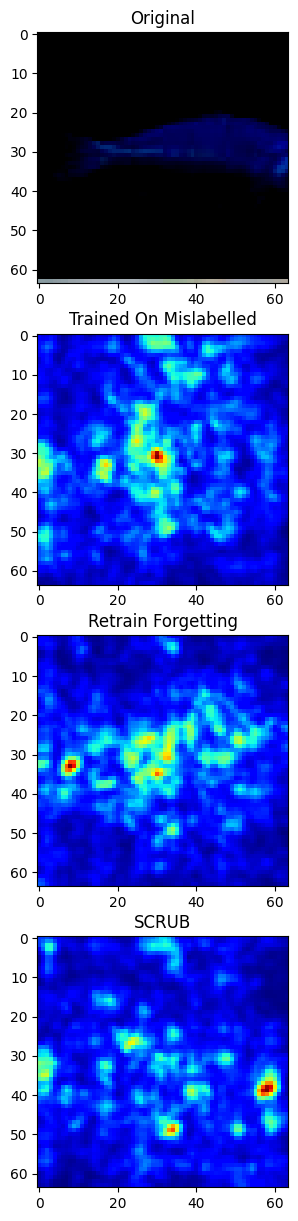

In [193]:
HeatMap(12)

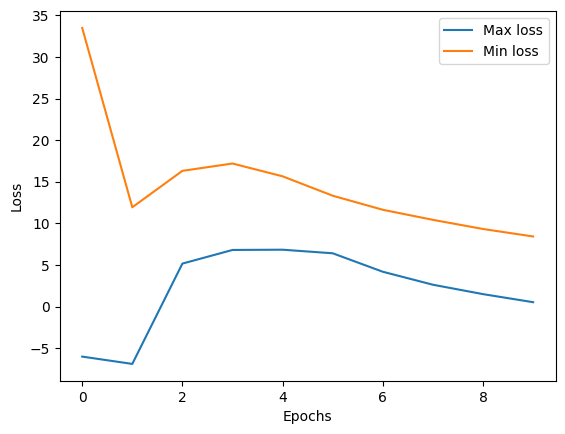

In [201]:
a = [-6.02, -6.90, 5.16, 6.8, 6.83, 6.4, 4.18, 2.62, 1.49, 0.52]
b = [33.49, 11.93, 16.31, 17.19, 15.65, 13.32, 11.63, 10.42, 9.32, 8.42]
y = list(range(10))
plt.plot(y, a, label = 'Max loss')
plt.plot(y, b, label = 'Min loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()